# Estimation Exercise

**Goal.** In version 1 of the KW94 model with (quasi-)hyperbolic discounting and completely naive agents, recover the true effect of a 500 USD tuition subsidy on average final experience by occupation for different values of $\beta$.

Then, compare the true effect with the effect predicted by the classic KW94 model, which in this context is misspecified in the sense that the agents discount exponentially. 

In [3]:
import numpy as np
import pandas as pd
import tqdm
import pickle
import glob

import respy as rp
from estimagic.optimization.optimize import minimize

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", font_scale=1.5, rc={'figure.figsize':(12,9)})

### Generate Observed Data and True Counterfactual

In [2]:
def generate_true_data(params, options, betas, policy):
    """Generate datasets for hyperbolic version of KW94. For each
    value of the present-bias parameter, one dataset is generated.
    Results are stored in a dictionary. 
    
    Params:
        betas (list of floats): Values of present-bias parameter.
        policy (string): "subsidy", "no_subsidy". Whether to generate 
            data including a 500 USD subsidy.  
            
    """
    params_beta = params.copy()
    
    if policy == "subsidy":
        params_beta.loc[("nonpec_edu", "at_least_twelve_exp_edu"), "value"] = 500
        
    dict_data = {}
    
    for beta in tqdm.tqdm(betas):
        params_beta.loc[("beta", "beta"), ["value", "comment"]] = [
            beta,
            "present-bias parameter",
        ]

        simulate = rp.get_simulate_func(params_beta, options)
        df = simulate(params_beta)
        
        dict_data["beta_" + str(beta)] = df
    
    return dict_data

In [3]:
# Get parameters and options for KW94
params, options = rp.get_example_model("kw_94_one", with_data=False)

In [4]:
# Choose values of present bias
betas = [float("{:.3f}".format(x)) for x in np.linspace(0.66, 1, num=18)]

In [5]:
# Generate observed data
dict_data = generate_true_data(params, options, betas, "no_subsidy")

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:25<00:00,  4.78s/it]


In [6]:
# Generate true counterfactual (including 500 USD tuition subsidy)
dict_data_sub = generate_true_data(params, options, betas, "subsidy")

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:22<00:00,  4.56s/it]


In [7]:
pickle.dump(dict_data, open('dict_data.pkl', 'wb'))

In [8]:
pickle.dump(dict_data_sub, open('dict_data_sub.pkl', 'wb'))

### Estimate Misspecified Model

A misspecified model -- i.e. the original KW94, where agents are time-consistent and `delta` is set to 0.95-- is estimated on each dataframe in `data` via the Method of Simulated Moments. 

**Constraints for KW94**

In [9]:
constraints = rp.get_parameter_constraints("kw_94_one")

**Estimation exercise.** For each dataframe in `data`:

1. We compute the empirical moments;
2. We compute the criterion function;
3. We run the optimization.

The estimates are stored in a dictionary.

In [20]:
def compute_msm_estimates(params, options, constraints, dict_data):
    """Estimate model described by `params` and `options` on each 
    dataframe in `data`, via the method of simulated moments. Store 
    results in a dictionary.
    
    """
    dict_estimates = {}
    
    for key, df in tqdm.tqdm(dict_data.items()):
    
        # Compute empirical moments
        empirical_moments = calc_moments(df)
        empirical_moments = fill_nans_zero(empirical_moments)

        # Weighting matrix is simply identity matrix for now
        weighting_matrix = rp.get_diag_weighting_matrix(empirical_moments)

        # Get msm function
        msm = rp.get_msm_func(
            params=params,
            options=options,
            calc_moments=calc_moments,
            replace_nans = fill_nans_zero,
            empirical_moments=empirical_moments,
            weighting_matrix = weighting_matrix
        )

        # Run optimization
        estimates = minimize(
            criterion=msm, params=params, logging=f"logging_{key}.db", algorithm="nlopt_bobyqa", constraints=constraints
        )

        # Store estimates in dictionary
        dict_estimates[key] = estimates
    
    return dict_estimates

In [21]:
def calc_moments(df):
    choices = df.groupby("Period").Choice.value_counts(normalize=True).unstack()
    wages = df.groupby(['Period'])['Wage'].describe()[['mean', 'std']]

    return pd.concat([choices, wages], axis=1)

In [22]:
def fill_nans_zero(df):
    return df.fillna(0)

In [24]:
dict_estimates = compute_msm_estimates(params, options, constraints, dict_data)

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]c:\users\sofia\projects\ose\respy\respy\solve.py:81: RuntimeWarning: overflow encountered in exp
  wages[:, i] = np.exp(log_wage)
  6%|████▍                                                                           | 1/18 [04:16<1:12:40, 256.51s/it]c:\users\sofia\projects\ose\respy\respy\solve.py:81: RuntimeWarning: overflow encountered in exp
  wages[:, i] = np.exp(log_wage)
 11%|████████▉                                                                       | 2/18 [08:35<1:08:35, 257.20s/it]c:\users\sofia\projects\ose\respy\respy\solve.py:81: RuntimeWarning: overflow encountered in exp
  wages[:, i] = np.exp(log_wage)
 17%|█████████████▎                                                                  | 3/18 [12:53<1:04:21, 257.42s/it]c:\users\sofia\projects\ose\respy\respy\solve.py:81: RuntimeWarning: overflow encountered in exp
  wages[:, i] = np.exp(log_wage)
 22%

In [25]:
pickle.dump(dict_estimates, open('miss_estimates.pkl', 'wb'))

### Simulate Data Using Misspecified Model Estimates

Simulate data using estimates from misspecified model, including a 500 USD tuition subsidy.

In [71]:
def simulate_data_from_dict(dict_params, options):
    """Simulate tuition subsidy data (500 USD) from dictionary of 
    parameters' estimates.
    
    Params:
        dict_params
        options
    
    """    
    dict_data = {}
    
    for key in tqdm.tqdm(dict_params.keys()):
        
        params = dict_estimates[key][1]
        params.loc[("nonpec_edu", "at_least_twelve_exp_edu"), "value"] = 500
        simulate = rp.get_simulate_func(params, options)
        df = simulate(params)
        
        dict_data[key] = df
        
    return dict_data

In [72]:
dict_data_sim = simulate_data_from_dict(dict_estimates, options)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:22<00:00,  4.61s/it]


In [73]:
pickle.dump(dict_data_sim, open('dict_data_sim.pkl', 'wb'))

### Results

We want to compare the true effect of a USD 500 tuition subsidy with the predicted effect under the misspecified model.

In [4]:
with open ('dict_data.pkl', 'rb') as f:  
    dict_data = pickle.load(f)

In [5]:
with open ('dict_data_sub.pkl', 'rb') as f:  
    dict_data_sub = pickle.load(f)

In [6]:
with open ('dict_data_sim.pkl', 'rb') as f:  
    dict_data_sim = pickle.load(f)

In [7]:
betas = [float("{:.3f}".format(x)) for x in np.linspace(0.66, 1, num=18)]

**Dataset with results**

In [15]:
def compute_sub_effect(dict_data, dict_data_sub, betas):
    """Compute effect of subsidy and return dataframe of results."""
     
    mom = pd.DataFrame(index=(range(0, len(betas))))
    
    mom["Present_Bias"] = betas
    moments = ["Experience_Edu", "Experience_A", "Experience_B"]

    for moment in moments:

        exp_sub = compute_mean_final_exp(dict_data_sub, moment)
        exp_no_sub = compute_mean_final_exp(dict_data, moment)

        mom[moment] = np.subtract(exp_sub, exp_no_sub) / exp_no_sub

    return mom.set_index("Present_Bias")

In [16]:
def compute_mean_final_exp(dict_data, mom):
    """For each dataframe in dictionary, compute average experience in final period."""
    data_mean_final_exp = [df.query("Period == 39")[mom].mean() for df in dict_data.values()] 
    
    return np.array(data_mean_final_exp)

In [17]:
exp_data = [compute_sub_effect(dict_data, mydict, betas) for mydict in [dict_data_sub, dict_data_sim]]
exp_data_df = pd.concat(exp_data, keys=("True", "Estimated"), axis=1)

In [18]:
exp_data_df.tail(12)

True                                Estimated  \
             Experience_Edu Experience_A Experience_B Experience_Edu   
Present_Bias                                                           
0.78               0.012182    -0.075848     0.167195      -0.009607   
0.80               0.015480    -0.090793     0.176570      -0.014001   
0.82               0.017918    -0.097581     0.163514       0.162832   
0.84               0.028940    -0.123990     0.178828       0.153346   
0.86               0.040909    -0.143965     0.178955       0.143132   
0.88               0.046228    -0.160705     0.172990       0.122708   
0.90               0.058911    -0.172252     0.152741       0.101772   
0.92               0.077237    -0.204346     0.149695       0.083673   
0.94               0.092792    -0.226313     0.135961       0.080543   
0.96               0.100748    -0.240139     0.117785       0.150017   
0.98               0.102744    -0.247474     0.099624       0.135065   
1.00               0.107090    -0.257464     0.081278       0.107090   

                                        
             Experience_A Experience_B  
Present_Bias                            
0.78             0.485207    -1.000000  
0.80             0.537043    -1.000000  
0.82            -0.210992     0.288983  
0.84            -0.176245     0.197052  
0.86            -0.140787     0.123503  
0.88            -0.090747     0.049129  
0.90            -0.026157    -0.022812  
0.92            -0.100833     0.053655  
0.94            -0.195024     0.118587  
0.96            -0.201586     0.064747  
0.98            -0.289680     0.109167  
1.00            -0.257464     0.081278

**Plots**

In [19]:
def plot_sub_effect_comparison(df, moment, mom):
    ax = sns.lineplot(
    x="Present_Bias", y="value", hue="Effect", ci=None, data=df.query("Moment == @moment")
    )
    ax.set_title("Effect of Tuition Subsidy (500 USD) on Experience in " + mom, y=1.025)
    ax.set_ylabel("Percentage Change")
    ax.set_xlabel("Present Bias")
    plt.show()

In [20]:
melted_df = pd.melt(exp_data_df.reset_index(), id_vars="Present_Bias", var_name=["Effect", "Moment"])

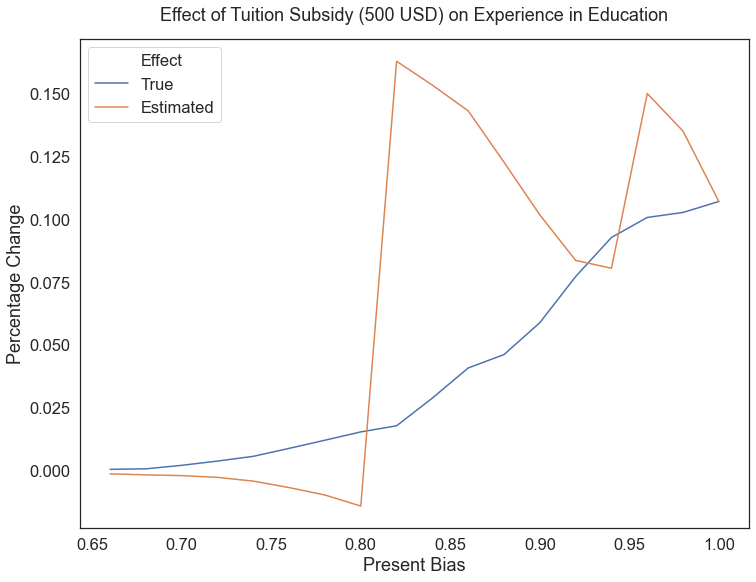

In [21]:
plot_sub_effect_comparison(melted_df, 'Experience_Edu', "Education")

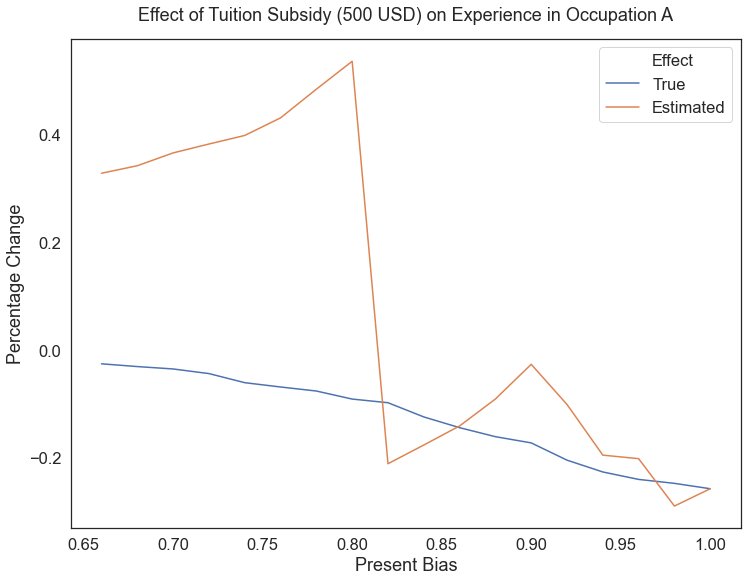

In [22]:
plot_sub_effect_comparison(melted_df, 'Experience_A', "Occupation A")

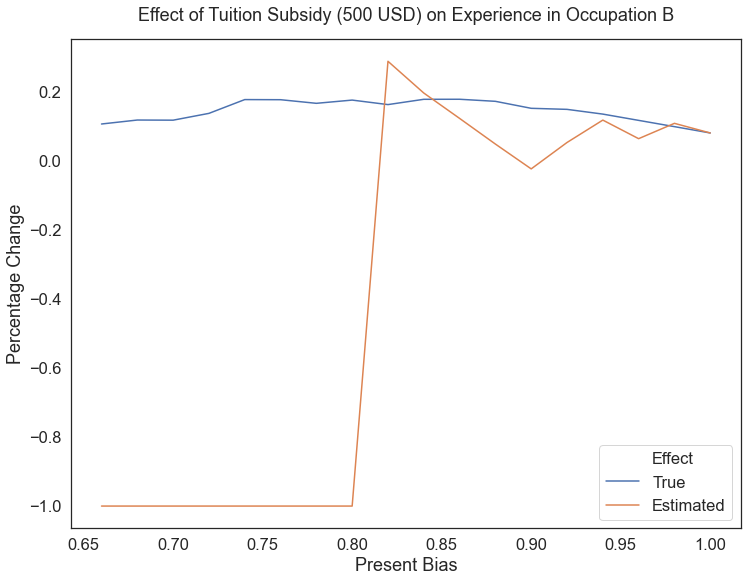

In [23]:
plot_sub_effect_comparison(melted_df, 'Experience_B', "Occupation B")